This colab accompanies the HierText dataset \[[Github](https://github.com/google-research-datasets/hiertext#evaluation)\].

This colab visualizes the annotations by coloring words/lines/paragraphs. Text entities that are annotated as illigeble have white color.

# Setting paths and visualization parameters

In [1]:
# Subset to inspect
SUBSET = 'validation'  # 'train' or 'validation'.

# Path to the image directory. Under this directory, there should be folders
# for 'train', 'validation', 'test' images.
IMAGE_DIR_PATH = ''

# Path to the annotation directory.
ANN_DIR_PATH = 'gt'

# The size of figure in visualization
FIG_SIZE = 15

# Visualization functions

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
# Load annotations
import json

IMAGE_SUBSET_DIR_PATH = os.path.join(IMAGE_DIR_PATH, SUBSET)
ANN_PATH = os.path.join(ANN_DIR_PATH, f'{SUBSET}.jsonl')
anns = json.load(open(ANN_PATH, 'r'))['annotations']

keys = [ann['image_id'] for ann in anns]
print(f'{len(anns)} samples loaded.')

1724 samples loaded.


In [4]:
def draw_mask(vertices, w, h):
  mask = np.zeros((h, w, 3), dtype=np.float32)
  mask = cv2.fillPoly(mask, [vertices], [1.] * 3)[:, :, 0]
  return mask


def stack_word_masks(mask, word_mask):
  return (mask + word_mask > 0.).astype(np.float32)

def load_img(image_id):
  return cv2.imread(os.path.join(IMAGE_SUBSET_DIR_PATH, f'{image_id}.jpg'))


def parse_annotation_dict(ann):
  image_id = ann['image_id']
  print(f'Processing image {image_id}')
  image = load_img(image_id)
  w = ann['image_width']
  h = ann['image_height']

  gt_word_masks = []
  gt_word_weights = []
  gt_word_texts = []

  gt_line_masks = []
  gt_line_weights = []
  gt_line_texts = []

  gt_paragraph_masks = []
  gt_paragraph_weights = []

  for paragraph in ann['paragraphs']:
    gt_paragraph_mask = np.zeros((h, w), dtype=np.float32)
    for line in paragraph['lines']:
      gt_line_mask = np.zeros((h, w), dtype=np.float32)
      for word in line['words']:
        gt_word_weights.append(1.0 if word['legible'] else 0.0)
        gt_word_texts.append(word['text'])
        vertices = np.array(word['vertices'])
        gt_word_mask = draw_mask(vertices, w, h)
        gt_word_masks.append(gt_word_mask)
        gt_line_mask = stack_word_masks(gt_line_mask, gt_word_mask)
        gt_paragraph_mask = stack_word_masks(gt_paragraph_mask,
                                             gt_word_mask)
      gt_line_masks.append(gt_line_mask)
      gt_line_weights.append(1.0 if line['legible'] else 0.0)
      gt_line_texts.append(line['text'])
    if not paragraph['legible']:
      gt_paragraph_mask = draw_mask(np.array(paragraph['vertices']), w, h)
    gt_paragraph_masks.append(gt_paragraph_mask)
    gt_paragraph_weights.append(1.0 if paragraph['legible'] else 0.0)

  num_gt_words = len(gt_word_masks)
  word_dict = {
      'gt_weights': (np.array(gt_word_weights) if num_gt_words else np.zeros(
          (0,), np.float32)),
      'gt_masks': (np.stack(gt_word_masks, -1) if num_gt_words else np.zeros(
          ((h + 1) // 2, (w + 1) // 2, 0), np.float32)),
      'gt_texts': (np.array(gt_word_texts) if num_gt_words else np.zeros(
          (0,), str)),
  }

  num_gt_lines = len(gt_line_masks)
  line_dict = {
      'gt_weights': (np.array(gt_line_weights) if num_gt_lines else np.zeros(
          (0,), np.float32)),
      'gt_masks': (np.stack(gt_line_masks, -1) if num_gt_lines else np.zeros(
          ((h + 1) // 2, (w + 1) // 2, 0), np.float32)),
      'gt_texts': (np.array(gt_line_texts) if num_gt_lines else np.zeros(
          (0,), str)),
  }

  num_gt_paragraphs = len(gt_paragraph_masks)
  paragraph_dict = {
      'gt_weights':
          (np.array(gt_paragraph_weights) if num_gt_paragraphs else np.zeros(
              (0,), np.float32)),
      'gt_masks':
          (np.stack(gt_paragraph_masks, -1) if num_gt_paragraphs else np.zeros(
              ((h + 1) // 2, (w + 1) // 2, 0), np.float32)),
  }
  return image, word_dict, line_dict, paragraph_dict

In [5]:
def visualize(text_dict):
  h, w, n_mask = text_dict['gt_masks'].shape
  if not n_mask:
    return np.zeros((h, w, 3), np.float32)
  palette = np.random.uniform(0.0, 1., (n_mask, 3))
  colored = np.reshape(np.matmul(
        np.reshape(text_dict['gt_masks'], (-1, n_mask)), palette), (h, w, 3))
  dont_care_mask = (np.reshape(np.matmul(
        np.reshape(text_dict['gt_masks'], (-1, n_mask)),
        np.reshape(1.- text_dict['gt_weights'], (-1, 1))), (h, w, 1)) > 0).astype(np.float32)

  filtered = np.clip(dont_care_mask * 1. + (1. - dont_care_mask) * colored, 0., 1.)

  plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
  plt.imshow(filtered)
  plt.show()


# Visualize samples

In [6]:
SAMPLE_ID = 4

image, word_dict, line_dict, para_dict = parse_annotation_dict(anns[SAMPLE_ID])

Processing image 00bb9343208cd7f0


Image

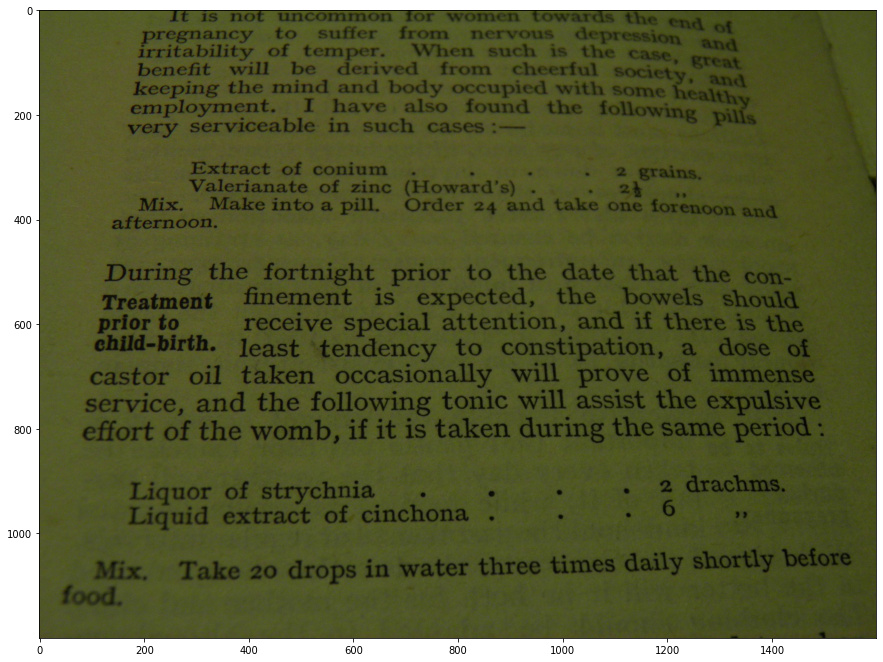

In [7]:
plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
plt.show()

Word annotation:

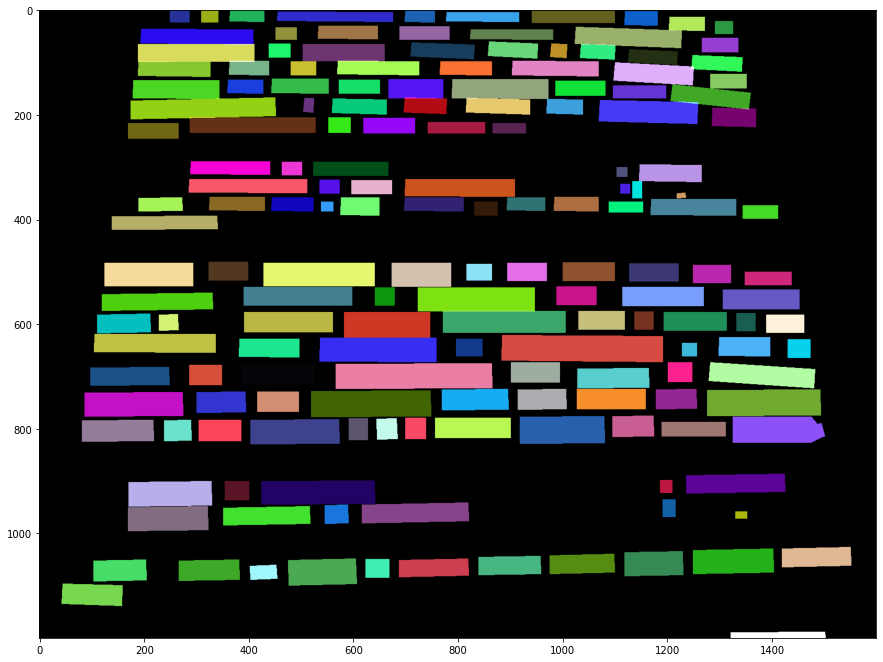

In [11]:
visualize(word_dict)

Line grouping

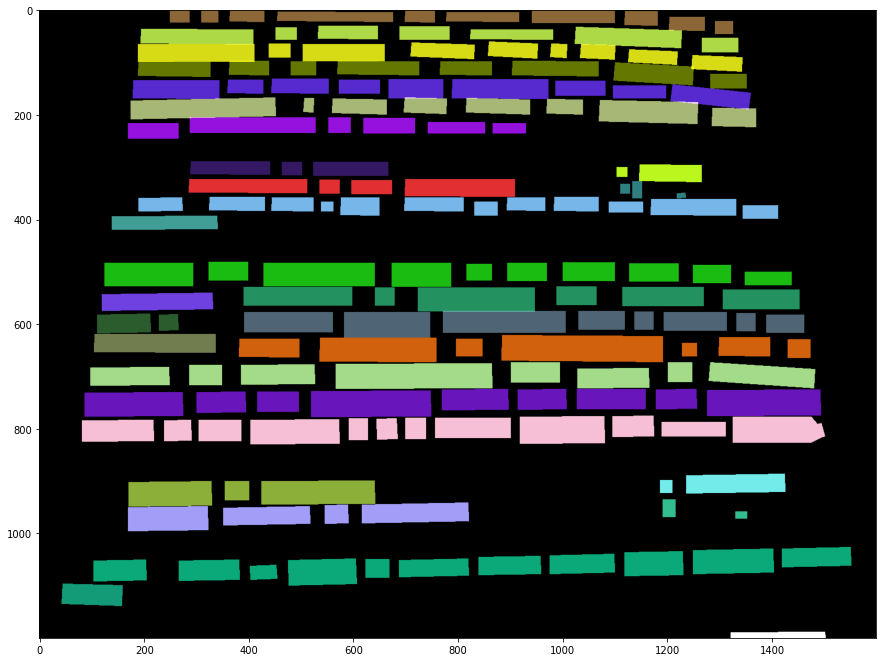

In [12]:
visualize(line_dict)

Paragraph grouping

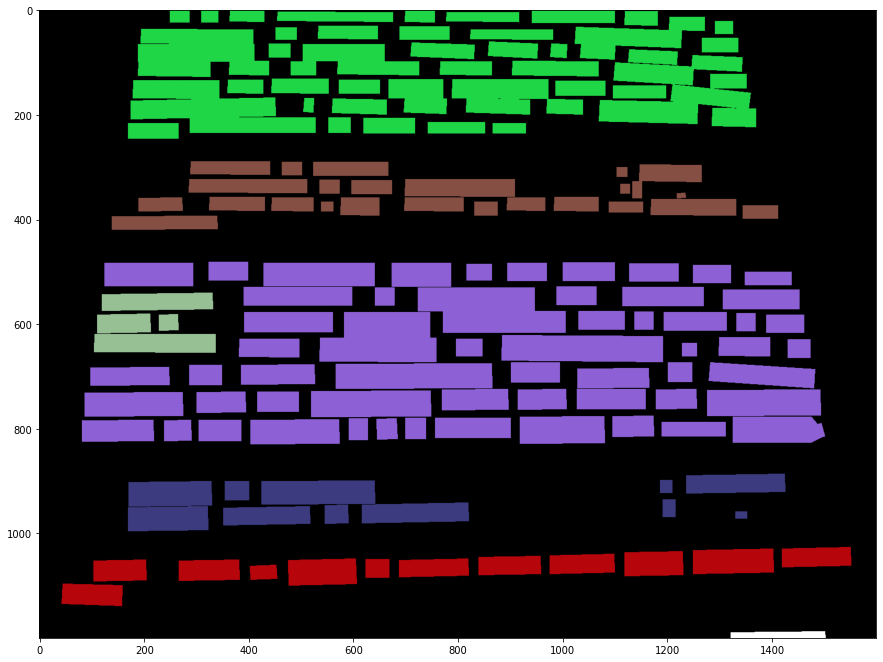

In [13]:
visualize(para_dict)